In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import Stemmer
#from nltk.stem.snowball import SnowballStemmer

import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

#stemmer = SnowballStemmer('english')
stemmer = Stemmer.Stemmer('english')

In [2]:
z = zipfile.ZipFile('train.csv.zip')
df_train = pd.read_csv(z.open('train.csv'),encoding="ISO-8859-1")
z = zipfile.ZipFile('test.csv.zip')
df_test = pd.read_csv(z.open('test.csv'),encoding="ISO-8859-1")
z = zipfile.ZipFile('product_descriptions.csv.zip')
df_pro_desc = pd.read_csv(z.open('product_descriptions.csv'))
z = zipfile.ZipFile('attributes.csv.zip')
df_attributes = pd.read_csv(z.open('attributes.csv'))
df_attributes = df_attributes.drop('name',axis=1)

In [3]:
df_attributes.value = df_attributes.value.astype(str)
df_attributes.head(2)

,product_uid,value
0,100001,Versatile connector for various 90° connection...
1,100001,Stronger than angled nailing or screw fastenin...


In [4]:
df_att_merged = df_attributes.groupby('product_uid').apply(lambda x: ' '.join(x.value) ).reset_index()
#                                                           if isinstance(x.value,str) \
#                                                          else ''.join(' '))
df_att_merged.columns = ['product_uid','prod_detail']
df_att_merged.head(3)

,product_uid,prod_detail
0,100001,Versatile connector for various 90° connection...
1,100002,"Brush,Roller,Spray 6.63 in 7.76 in 6.63 in Rev..."
2,100003,Yes Slightly narrower for tighter spaces Desig...


In [5]:
df_train.head(5)

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [28]:
import re

num_train = df_train.shape[0]

def str_stemmer_new(s):
    stemmed = ''
    if isinstance(s,str):
#        word_list = s.split(' ')
        word_list = re.findall(r"[\w']+", s)
        for word in word_list:
            if isinstance(word, basestring):
                stemmed = stemmed + ' ' + stemmer.stemWord(word.lower())
            else:
                stemmed = stemmed + str(s)
        return stemmed
    else:
        return str(s)

def str_stemmer(s):
	return " ".join([stemmer.stemWord(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())


In [21]:
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')
df_all = pd.merge(df_all, df_att_merged, how='left', on='product_uid')


In [24]:
#test = df_all.head(5)
#test['prod_detail'] = test['prod_detail'].map(lambda x:str_stemmer(x))
df_all['prod_detail'] = df_all['prod_detail'].map(lambda x:str_stemmer_new(x))
#print(test.prod_detail)


In [26]:
df_all.head(3)

,id,product_title,product_uid,relevance,search_term,product_description,prod_detail
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.0,angle bracket,"Not only do angles make joints stronger, they ...",versatil connector for various 90 connect and...
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.5,l bracket,"Not only do angles make joints stronger, they ...",versatil connector for various 90 connect and...
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.0,deck over,BEHR Premium Textured DECKOVER is an innovativ...,brush roller spray 6 63 in 7 76 in 6 63 in re...


In [29]:
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

In [30]:
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

In [260]:
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']+"\t" \
                        +df_all['prod_detail']
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))
df_all['word_in_detail'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[3]))
df_all = df_all.drop(['search_term','product_title','product_description','product_info','prod_detail'],axis=1)

21985
4604


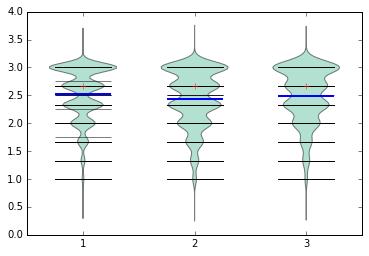

In [246]:
# Matching first word of search with first word of title
first_search_term = df_all.search_term.map(lambda x: x.split()[0])
first_word_title = df_all.product_title.map(lambda x: x.split()[0])
first = df_all[first_search_term == first_word_title].relevance
print(len(first))

# Matching second word of search with second word of title

def term(s,n):
    if len(s.split())>n:
        return s.split()[n]

second_word_title = df_all.product_title.apply(lambda x: term(x,1))
second_search_term = df_all.search_term.apply(lambda x: term(x,1))
second = df_all[second_search_term == second_word_title].relevance

both = df_all[(second_search_term == second_word_title) & (first_search_term == first_word_title)].relevance
print(len(both))

from statsmodels.graphics.boxplots import beanplot
beanplot([first.dropna().values,second.dropna().values,both.dropna().values])
plt.show()

Hmmm, it seems detecting for both the first and second common words does NOT improve the spread or average relevance from just detecting the first word... Not something I would have expected.

In [116]:
df_all[df_all.search_term == '8 4616809045 9'].head(3)

,id,product_title,product_uid,relevance,search_term,product_description,prod_detail,len_of_query,product_info,word_in_title,word_in_description,word_in_detail
44,164,9.1 in. x 5.8 in. white design shelf bracket,100030,1.67,8 4616809045 9,white design shelf bracket offer a stylish alt...,weight capac of 100 lbs per pair of bracket w...,3,8 4616809045 9\t9.1 in. x 5.8 in. white design...,2,0,0
3585,11108,magic chef 23.8 in. w 9.2 cu. ft. bottom freez...,101918,3.00,8 4616809045 9,the magic chef 9.2 cu. ft. bottom freezer comp...,bottom freezer refriger energi star qualifi m...,3,8 4616809045 9\tmagic chef 23.8 in. w 9.2 cu. ...,2,2,2
5097,15951,louisvill ladder premium seri 7 ft. - 8 ft. 9 ...,102809,1.67,8 4616809045 9,the premium seri wood attic ladder from louisv...,wood rail and rung offer solid support and la...,3,8 4616809045 9\tlouisvill ladder premium seri ...,2,1,1


33355
37223
18583


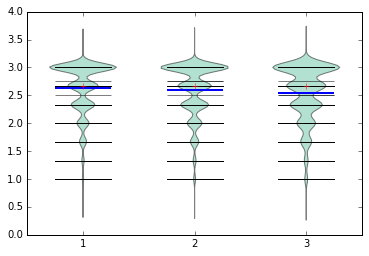

In [249]:
# Look at cases where all search term words coincide with product 1) title, 2) description and 3) detail
ratio1 = df_all.word_in_title/df_all.len_of_query
print(len(df_all.relevance[ratio1==1.0]))
ratio2 = df_all.word_in_description/df_all.len_of_query
print(len(df_all.relevance[ratio2==1.0]))
ratio3 = df_all.word_in_detail/df_all.len_of_query
print(len(df_all.relevance[ratio3==1.0]))
beanplot([df_all.relevance[ratio1==1.0].dropna().values,df_all.relevance[ratio2==1.0].dropna().values,df_all.relevance[ratio3==1.0].dropna().values])
plt.show()

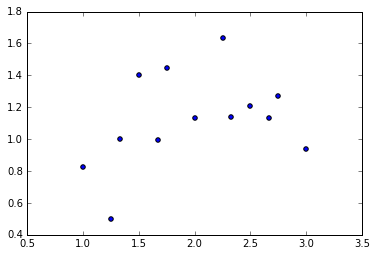

In [113]:
import scipy
avg_words_in_detail = df_all.groupby('relevance')['word_in_detail'].apply(scipy.mean).reset_index()
plt.scatter(avg_words_in_detail.iloc[:,0],avg_words_in_detail.iloc[:,1])

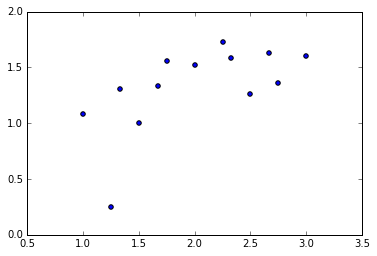

In [114]:
avg_words_in_description = df_all.groupby('relevance')['word_in_description'].apply(scipy.mean).reset_index()
plt.scatter(avg_words_in_description.iloc[:,0],avg_words_in_description.iloc[:,1])

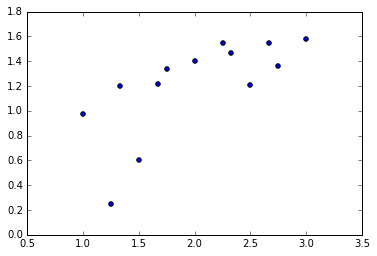

In [115]:
avg_words_in_title = df_all.groupby('relevance')['word_in_title'].apply(scipy.mean).reset_index()
plt.scatter(avg_words_in_title.iloc[:,0],avg_words_in_title.iloc[:,1])

In [261]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']


In [291]:
y_train = df_train['relevance'].values
y_test = df_test['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values
print(y_test[0:2])
print(y_train[0:2])
print(X_test[0:2])

[ nan  nan]
[ 3.   2.5]
[[100001      3      0      1      1]
 [100001      3      1      1      1]]


In [263]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

In [287]:
#RMSE
from sklearn.metrics import mean_squared_error as mse

def rmse(true,pred):
    mse = 0
    for i in range(len(true)):
        if true[i] is float:
            mse += (true[i] - pred[i])**2
            print mse
    return mse**0.5

In [288]:
rmse(y_test[0:100],y_pred[0:100])

0.0

In [290]:
y_test[1]

nan